In [306]:
# load packages
#basics
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#sklearn
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler

#tensorflow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, TimeDistributed, Masking, Dense, LSTM, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences 

In [307]:
# loading data for model building
df = pd.read_csv("C:\work\le_wagon\data\df_model_lc_2015_2024.csv")
df.drop("Unnamed: 0", axis=1, inplace=True)

In [308]:
# Normalize the features
scaler = MinMaxScaler()
features = ['temperature_quarterly_mean', 'precipitation_quarterly_mean', 'water-vapor-pressure_quarterly_mean', 'cloud-cover_quarterly_mean']
df[features] = scaler.fit_transform(df[features])
df.tail()


,SITECODE,date,lon,lat,Bare Ground,Built Area,Crops,Flooded Vegetation,Grass,Shrub and Scrub,Snow and Ice,Trees,Water,temperature_quarterly_mean,precipitation_quarterly_mean,water-vapor-pressure_quarterly_mean,cloud-cover_quarterly_mean
22376,SE0820042,2024-04-01,22.080295,65.631796,0.0,0.0,0.0,0.0,0.0,0.0,96.868297,1.987538,0.0,0.434977,0.227272,0.302596,0.685456
22377,SE0820295,2024-04-01,18.212619,67.150809,0.0,0.0,0.0,0.0,0.0,0.0,99.995652,0.000000,0.0,0.333259,0.269177,0.225109,0.827125
22378,SE0820614,2024-04-01,20.350211,66.053867,0.0,0.0,0.0,0.0,0.0,0.0,99.987998,0.000000,0.0,0.457060,0.251558,0.279906,0.750269
22379,SE0820615,2024-04-01,20.949495,66.373559,0.0,0.0,0.0,0.0,0.0,0.0,99.995901,0.000000,0.0,0.466652,0.237492,0.282782,0.745707
22380,SE0820616,2024-04-01,21.194107,66.652113,0.0,0.0,0.0,0.0,0.0,0.0,99.996812,0.000000,0.0,0.438099,0.260678,0.269406,0.771164


In [309]:
# Prepare the sequences
site_codes = df['SITECODE'].unique()        # 624 unique site codes
sequences = []
targets = []

for site_code in site_codes:
    site_data = df[df['SITECODE'] == site_code].sort_values('date')   # get weather data sorted by date for one site
    sequences.append(site_data[features].values)
    targets.append(site_data[['Bare Ground', 'Built Area', 'Crops', 'Flooded Vegetation', 'Grass', 'Shrub and Scrub', 'Snow and Ice', 'Trees', 'Water']].values)

# Pad sequences to ensure uniform length
max_seq_length = max(len(seq) for seq in sequences)
sequences = pad_sequences(sequences, maxlen=max_seq_length, dtype='float32', padding='post')
targets = pad_sequences(targets, maxlen=max_seq_length, dtype='float32', padding='post')

# Convert to numpy arrays
sequences = np.array(sequences)
targets = np.array(targets)

In [247]:
# Split the data into training and testing sets   (update to not mix train and test data time stamps)
#X_train = sequences[0:499]
#X_test  = sequences[499:] 
#y_train = targets[0:499]
#y_test  = targets[499:]

#X_train.shape, X_test.shape, y_train.shape, y_test.shape



((499, 36, 4), (125, 36, 4), (499, 36, 9), (125, 36, 9))

In [310]:
# Split the data into training and testing sets   (update to not mix train and test data time stamps)
X_train, X_test, y_train, y_test = train_test_split(sequences, targets, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((499, 36, 4), (125, 36, 4), (499, 36, 9), (125, 36, 9))

In [311]:
# Define the RNN model
model = Sequential()
model.add(Masking(mask_value=0.0, input_shape=(X_train.shape[1], X_train.shape[2])))  # Mask padding values

model.add(SimpleRNN(100, activation='relu', return_sequences=True))

#model.add(LSTM(100, activation='relu', return_sequences=True))

model.add(Dropout(0.2))

model.add(SimpleRNN(50, activation='relu', return_sequences=True))

model.add(TimeDistributed(Dense(100, activation = 'relu')))  
model.add(TimeDistributed(Dense(9, activation = 'linear'))) # 9 targets

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
#model.summary()

# Train the model
history = model.fit(X_train, y_train, epochs=50, validation_split=0.2)


Epoch 1/50


c:\Users\T\anaconda3\Lib\site-packages\keras\src\layers\core\masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 15s 240ms/step - accuracy: 0.3440 - loss: 590.2556 - val_accuracy: 0.5167 - val_loss: 450.6523
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5006 - loss: 458.2095 - val_accuracy: 0.5167 - val_loss: 370.4750
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.4806 - loss: 379.6575 - val_accuracy: 0.5167 - val_loss: 351.2065
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.4806 - loss: 366.6217 - val_accuracy: 0.5167 - val_loss: 344.4117
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.4869 - loss: 366.1387 - val_accuracy: 0.5167 - val_loss: 343.7130
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.4940 - loss: 357.6346 - val_accuracy: 0.5167 - val_loss: 342.6604
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5133 - loss: 349.6815 - val_accuracy: 0.5167 - val_loss: 337.8546
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.4946 - loss: 360.7430 - val

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5547 - loss: 266.6981 
Test Accuracy: 0.55%


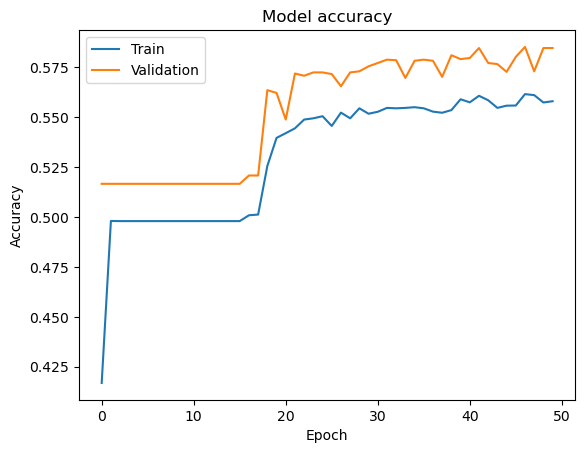

In [312]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy:.2f}%')

# Plot training & validation accuracy values
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [313]:
X_pred = pd.read_csv('C:/work/le_wagon/data/all_pa_future_values_2100.csv')
X_pred['quarter_start'] = pd.to_datetime(X_pred['quarter_start'])
X_pred.drop('lon', axis = 1, inplace = True)
X_pred.drop('lat', axis = 1, inplace = True)
X_pred.sort_values(['SITECODE', 'quarter_start'], ascending = [True, True])

,SITECODE,quarter_start,temperature_quarterly_mean,precipitation_quarterly_mean,water-vapor-pressure_quarterly_mean,cloud-cover_quarterly_mean
495,AT1301000,2025-01-01,2.34,6.930439e-09,576.72850,0.630833
1153,AT1301000,2025-04-01,16.21,2.276661e-08,868.17285,0.590103
1811,AT1301000,2025-07-01,19.01,2.896477e-08,977.75055,0.535831
2469,AT1301000,2025-10-01,8.94,1.996293e-08,742.21330,0.628255
3127,AT1301000,2026-01-01,4.57,1.428263e-08,649.87256,0.646506
...,...,...,...,...,...,...
197236,SE0820616,2099-10-01,0.50,3.060677e-08,612.30390,0.808178
197894,SE0820616,2100-01-01,-6.23,8.557523e-09,463.40604,0.741276
198552,SE0820616,2100-04-01,6.94,2.292757e-08,651.59784,0.710243
199210,SE0820616,2100-07-01,10.88,3.731042e-08,780.79130,0.790892


In [314]:
# extract data for different timespans
X_pred_10 = X_pred[X_pred['quarter_start'] < pd.to_datetime('2035-01-01')]

# get sitecodes for all sites
sitecodes = X_pred['SITECODE'].unique()
#X_pred_10.drop_duplicates(inplace = True)
X_pred_10 = X_pred_10.sort_values(['SITECODE', 'quarter_start'], ascending = [True, True])
X_pred_10 = X_pred_10.drop_duplicates()
X_pred_10

,SITECODE,quarter_start,temperature_quarterly_mean,precipitation_quarterly_mean,water-vapor-pressure_quarterly_mean,cloud-cover_quarterly_mean
495,AT1301000,2025-01-01,2.34,6.930439e-09,576.72850,0.630833
1153,AT1301000,2025-04-01,16.21,2.276661e-08,868.17285,0.590103
1811,AT1301000,2025-07-01,19.01,2.896477e-08,977.75055,0.535831
2469,AT1301000,2025-10-01,8.94,1.996293e-08,742.21330,0.628255
3127,AT1301000,2026-01-01,4.57,1.428263e-08,649.87256,0.646506
...,...,...,...,...,...,...
23524,SE0820616,2033-10-01,-2.62,1.797151e-08,547.84270,0.793026
24182,SE0820616,2034-01-01,-8.91,8.058048e-09,414.09216,0.745535
24840,SE0820616,2034-04-01,3.61,2.254867e-08,587.55820,0.759367
25498,SE0820616,2034-07-01,11.80,3.497499e-08,790.18430,0.753207


In [315]:
X_pred_10_reduced = X_pred_10.copy()
X_pred_10_reduced.drop(columns = ['temperature_quarterly_mean',	'precipitation_quarterly_mean',	'water-vapor-pressure_quarterly_mean',	'cloud-cover_quarterly_mean'], inplace = True)

dropped = X_pred_10_reduced.drop_duplicates()
dropped

,SITECODE,quarter_start
495,AT1301000,2025-01-01
1153,AT1301000,2025-04-01
1811,AT1301000,2025-07-01
2469,AT1301000,2025-10-01
3127,AT1301000,2026-01-01
...,...,...
23524,SE0820616,2033-10-01
24182,SE0820616,2034-01-01
24840,SE0820616,2034-04-01
25498,SE0820616,2034-07-01


In [316]:
X_pred_10 = X_pred_10.groupby(['SITECODE','quarter_start']).mean()
X_pred_10.reset_index(inplace = True)
X_pred_10

,SITECODE,quarter_start,temperature_quarterly_mean,precipitation_quarterly_mean,water-vapor-pressure_quarterly_mean,cloud-cover_quarterly_mean
0,AT1301000,2025-01-01,2.34,6.930439e-09,576.72850,0.630833
1,AT1301000,2025-04-01,16.21,2.276661e-08,868.17285,0.590103
2,AT1301000,2025-07-01,19.01,2.896477e-08,977.75055,0.535831
3,AT1301000,2025-10-01,8.94,1.996293e-08,742.21330,0.628255
4,AT1301000,2026-01-01,4.57,1.428263e-08,649.87256,0.646506
...,...,...,...,...,...,...
24955,SE0820616,2033-10-01,-2.62,1.797151e-08,547.84270,0.793026
24956,SE0820616,2034-01-01,-8.91,8.058048e-09,414.09216,0.745535
24957,SE0820616,2034-04-01,3.61,2.254867e-08,587.55820,0.759367
24958,SE0820616,2034-07-01,11.80,3.497499e-08,790.18430,0.753207


In [317]:
X_pred_10['quarter_start'].unique()

<DatetimeArray>
['2025-01-01 00:00:00', '2025-04-01 00:00:00', '2025-07-01 00:00:00',
 '2025-10-01 00:00:00', '2026-01-01 00:00:00', '2026-04-01 00:00:00',
 '2026-07-01 00:00:00', '2026-10-01 00:00:00', '2027-01-01 00:00:00',
 '2027-04-01 00:00:00', '2027-07-01 00:00:00', '2027-10-01 00:00:00',
 '2028-01-01 00:00:00', '2028-04-01 00:00:00', '2028-07-01 00:00:00',
 '2028-10-01 00:00:00', '2029-01-01 00:00:00', '2029-04-01 00:00:00',
 '2029-07-01 00:00:00', '2029-10-01 00:00:00', '2030-01-01 00:00:00',
 '2030-04-01 00:00:00', '2030-07-01 00:00:00', '2030-10-01 00:00:00',
 '2031-01-01 00:00:00', '2031-04-01 00:00:00', '2031-07-01 00:00:00',
 '2031-10-01 00:00:00', '2032-01-01 00:00:00', '2032-04-01 00:00:00',
 '2032-07-01 00:00:00', '2032-10-01 00:00:00', '2033-01-01 00:00:00',
 '2033-04-01 00:00:00', '2033-07-01 00:00:00', '2033-10-01 00:00:00',
 '2034-01-01 00:00:00', '2034-04-01 00:00:00', '2034-07-01 00:00:00',
 '2034-10-01 00:00:00']
Length: 40, dtype: datetime64[ns]

In [318]:
X_pred_10

# Normalize the features
scaler = MinMaxScaler()
features = ['temperature_quarterly_mean', 'precipitation_quarterly_mean', 'water-vapor-pressure_quarterly_mean', 'cloud-cover_quarterly_mean']
X_pred_10[features] = scaler.fit_transform(X_pred_10[features])

# Prepare the sequences
site_codes = X_pred_10['SITECODE'].unique()
sequences = []

for site_code in site_codes:
    site_data = X_pred_10[X_pred_10['SITECODE'] == site_code].sort_values('quarter_start')
    sequences.append(site_data[features].values)
    #print(sequences)
    
# Pad sequences to ensure uniform length
#sequences = pad_sequences(sequences, maxlen=40, dtype='float32', padding='post')

# Convert to numpy arrays
sequences = np.array(sequences)

In [347]:
pwd

'c:\\Users\\T\\AppData\\Local\\Programs\\Microsoft VS Code'

In [319]:
predictions_10 = model.predict(sequences)
predictions_10.shape

20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 99ms/step


(624, 40, 9)

In [320]:
# reshape predictions into array
array = predictions_10

# Reshape the array to (24960, 9) where 24960 is 624 sites * 40 time points
reshaped_array = array.reshape(-1, 9)

# Create column names for the DataFrame
columns = [f'feature_{i}' for i in range(1, 10)]

# Create the DataFrame
df = pd.DataFrame(reshaped_array, columns=columns)

print("Shape of the DataFrame:", df.shape)
df

Shape of the DataFrame: (24960, 9)


,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9
0,1.366854,0.347755,2.463945,1.269822,4.752250,6.306211,2.078655,45.411003,14.155139
1,1.563102,0.601863,1.711044,0.894878,4.308317,5.098750,6.443186,27.723900,10.775125
2,0.699033,1.371915,6.020916,1.829166,2.405056,6.489323,29.918207,18.578747,10.717115
3,0.680867,0.814695,5.748261,3.538279,5.077255,12.489645,-3.487980,42.846127,18.075464
4,1.583300,0.596707,4.804341,1.863073,4.909122,6.887949,-0.678292,45.285816,15.212830
...,...,...,...,...,...,...,...,...,...
24955,3.836945,0.470812,1.491977,1.757094,3.979843,6.598513,34.259453,16.422607,1.228287
24956,1.623413,-0.241384,-0.269116,0.095185,-0.217577,2.631595,87.387840,0.814821,-2.983284
24957,0.857201,0.960066,-3.167170,3.027128,2.407858,9.336652,45.820175,18.319525,0.196236
24958,0.840371,0.485071,-2.996226,4.544093,8.453059,7.422012,4.325767,49.900352,5.659194


In [321]:
df.insert(0, "SITECODE", X_pred_10['SITECODE'], True)
df.insert(1, "quarter_start", X_pred_10['quarter_start'], True )


In [322]:
df.rename(columns={ 'feature_1': 'Bare Ground', 
                    'feature_2': 'Built Area', 
                    'feature_3': 'Crops', 
                    'feature_4': 'Flooded Vegetation' , 
                    'feature_5': 'Grass', 
                    'feature_6': 'Shrub and Scrub', 
                    'feature_7': 'Snow and Ice', 
                    'feature_8': 'Trees', 
                    'feature_9': 'Water'}, inplace = True)

In [323]:
df_predicted_lc = df.copy()
df_predicted_lc

,SITECODE,quarter_start,Bare Ground,Built Area,Crops,Flooded Vegetation,Grass,Shrub and Scrub,Snow and Ice,Trees,Water
0,AT1301000,2025-01-01,1.366854,0.347755,2.463945,1.269822,4.752250,6.306211,2.078655,45.411003,14.155139
1,AT1301000,2025-04-01,1.563102,0.601863,1.711044,0.894878,4.308317,5.098750,6.443186,27.723900,10.775125
2,AT1301000,2025-07-01,0.699033,1.371915,6.020916,1.829166,2.405056,6.489323,29.918207,18.578747,10.717115
3,AT1301000,2025-10-01,0.680867,0.814695,5.748261,3.538279,5.077255,12.489645,-3.487980,42.846127,18.075464
4,AT1301000,2026-01-01,1.583300,0.596707,4.804341,1.863073,4.909122,6.887949,-0.678292,45.285816,15.212830
...,...,...,...,...,...,...,...,...,...,...,...
24955,SE0820616,2033-10-01,3.836945,0.470812,1.491977,1.757094,3.979843,6.598513,34.259453,16.422607,1.228287
24956,SE0820616,2034-01-01,1.623413,-0.241384,-0.269116,0.095185,-0.217577,2.631595,87.387840,0.814821,-2.983284
24957,SE0820616,2034-04-01,0.857201,0.960066,-3.167170,3.027128,2.407858,9.336652,45.820175,18.319525,0.196236
24958,SE0820616,2034-07-01,0.840371,0.485071,-2.996226,4.544093,8.453059,7.422012,4.325767,49.900352,5.659194


In [324]:
X_pred = pd.read_csv('C:/work/le_wagon/data/all_pa_future_values_2100.csv')
X_pred['quarter_start'] = pd.to_datetime(X_pred['quarter_start'])
X_pred.drop('lon', axis = 1, inplace = True)
X_pred.drop('lat', axis = 1, inplace = True)
X_pred.sort_values(['SITECODE', 'quarter_start'], ascending = [True, True])

# extract data for different timespans
X_pred_10 = X_pred[X_pred['quarter_start'] < pd.to_datetime('2035-01-01')]

# get sitecodes for all sites
X_pred_10 = X_pred_10.sort_values(['SITECODE', 'quarter_start'], ascending = [True, True])
X_pred_10 = X_pred_10.drop_duplicates()
X_pred_10

X_pred_10 = X_pred_10.groupby(['SITECODE','quarter_start']).mean()
X_pred_10.reset_index(inplace = True)
X_pred_10


# get the predicted weather data for the future
df_temp_preds = X_pred_10
#df_temp_preds.rename(columns={ 'quarter_start': 'dat'})
df_temp_preds

,SITECODE,quarter_start,temperature_quarterly_mean,precipitation_quarterly_mean,water-vapor-pressure_quarterly_mean,cloud-cover_quarterly_mean
0,AT1301000,2025-01-01,2.34,6.930439e-09,576.72850,0.630833
1,AT1301000,2025-04-01,16.21,2.276661e-08,868.17285,0.590103
2,AT1301000,2025-07-01,19.01,2.896477e-08,977.75055,0.535831
3,AT1301000,2025-10-01,8.94,1.996293e-08,742.21330,0.628255
4,AT1301000,2026-01-01,4.57,1.428263e-08,649.87256,0.646506
...,...,...,...,...,...,...
24955,SE0820616,2033-10-01,-2.62,1.797151e-08,547.84270,0.793026
24956,SE0820616,2034-01-01,-8.91,8.058048e-09,414.09216,0.745535
24957,SE0820616,2034-04-01,3.61,2.254867e-08,587.55820,0.759367
24958,SE0820616,2034-07-01,11.80,3.497499e-08,790.18430,0.753207


In [325]:
# create a dataframe that combines the predicted weather data for the future and the predictions of landcover 
result = pd.merge(df_temp_preds, df_predicted_lc, on=["SITECODE",'quarter_start'])
result

,SITECODE,quarter_start,temperature_quarterly_mean,precipitation_quarterly_mean,water-vapor-pressure_quarterly_mean,cloud-cover_quarterly_mean,Bare Ground,Built Area,Crops,Flooded Vegetation,Grass,Shrub and Scrub,Snow and Ice,Trees,Water
0,AT1301000,2025-01-01,2.34,6.930439e-09,576.72850,0.630833,1.366854,0.347755,2.463945,1.269822,4.752250,6.306211,2.078655,45.411003,14.155139
1,AT1301000,2025-04-01,16.21,2.276661e-08,868.17285,0.590103,1.563102,0.601863,1.711044,0.894878,4.308317,5.098750,6.443186,27.723900,10.775125
2,AT1301000,2025-07-01,19.01,2.896477e-08,977.75055,0.535831,0.699033,1.371915,6.020916,1.829166,2.405056,6.489323,29.918207,18.578747,10.717115
3,AT1301000,2025-10-01,8.94,1.996293e-08,742.21330,0.628255,0.680867,0.814695,5.748261,3.538279,5.077255,12.489645,-3.487980,42.846127,18.075464
4,AT1301000,2026-01-01,4.57,1.428263e-08,649.87256,0.646506,1.583300,0.596707,4.804341,1.863073,4.909122,6.887949,-0.678292,45.285816,15.212830
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24955,SE0820616,2033-10-01,-2.62,1.797151e-08,547.84270,0.793026,3.836945,0.470812,1.491977,1.757094,3.979843,6.598513,34.259453,16.422607,1.228287
24956,SE0820616,2034-01-01,-8.91,8.058048e-09,414.09216,0.745535,1.623413,-0.241384,-0.269116,0.095185,-0.217577,2.631595,87.387840,0.814821,-2.983284
24957,SE0820616,2034-04-01,3.61,2.254867e-08,587.55820,0.759367,0.857201,0.960066,-3.167170,3.027128,2.407858,9.336652,45.820175,18.319525,0.196236
24958,SE0820616,2034-07-01,11.80,3.497499e-08,790.18430,0.753207,0.840371,0.485071,-2.996226,4.544093,8.453059,7.422012,4.325767,49.900352,5.659194


In [326]:
# reload the empirical weather and landcover data
df_empirical = pd.read_csv("C:\work\le_wagon\data\df_model_lc_2015_2024.csv")
df_empirical.drop(["Unnamed: 0", 'lat', 'lon'], axis=1, inplace=True)#

df_empirical['date'] = pd.to_datetime(df_empirical['date'])

df_empirical.rename(columns={ 'date': 'quarter_start'}, inplace = True)

df_empirical

,SITECODE,quarter_start,Bare Ground,Built Area,Crops,Flooded Vegetation,Grass,Shrub and Scrub,Snow and Ice,Trees,Water,temperature_quarterly_mean,precipitation_quarterly_mean,water-vapor-pressure_quarterly_mean,cloud-cover_quarterly_mean
0,AT1301000,2015-07-01,0.004731,0.306967,9.740933,0.434059,3.750812,1.101940,0.000000,79.647261,4.151655,18.86,2.788798e-08,942.75470,0.536892
1,AT1302000,2015-07-01,0.000079,0.450186,1.870178,0.062068,2.485236,0.504686,0.000000,94.372208,0.105224,18.12,3.174909e-08,948.60770,0.553719
2,AT1304000,2015-07-01,0.000000,3.427528,67.818286,0.180076,1.440462,1.265232,0.000000,24.646051,0.000000,18.12,3.174909e-08,948.60770,0.553719
3,AT2112000,2015-07-01,3.268027,0.178362,0.008970,0.550204,0.366961,13.011084,0.232740,82.268944,0.000000,13.15,5.000581e-08,891.69970,0.644521
4,AT2116000,2015-07-01,0.000000,0.845768,8.414334,0.328737,22.908775,0.229168,0.000000,58.175196,7.122431,13.15,5.000581e-08,891.69970,0.644521
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22376,SE0820042,2024-04-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,96.868297,1.987538,0.000000,4.58,2.618655e-08,643.23303,0.658696
22377,SE0820295,2024-04-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,99.995652,0.000000,0.000000,0.02,3.101494e-08,562.88360,0.794345
22378,SE0820614,2024-04-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,99.987998,0.000000,0.000000,5.57,2.898485e-08,619.70465,0.720756
22379,SE0820615,2024-04-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,99.995901,0.000000,0.000000,6.00,2.736414e-08,622.68720,0.716387


In [327]:
df_final = pd.concat([df_empirical,result], ignore_index=True)
df_final

,SITECODE,quarter_start,Bare Ground,Built Area,Crops,Flooded Vegetation,Grass,Shrub and Scrub,Snow and Ice,Trees,Water,temperature_quarterly_mean,precipitation_quarterly_mean,water-vapor-pressure_quarterly_mean,cloud-cover_quarterly_mean
0,AT1301000,2015-07-01,0.004731,0.306967,9.740933,0.434059,3.750812,1.101940,0.000000,79.647261,4.151655,18.86,2.788798e-08,942.75470,0.536892
1,AT1302000,2015-07-01,0.000079,0.450186,1.870178,0.062068,2.485236,0.504686,0.000000,94.372208,0.105224,18.12,3.174909e-08,948.60770,0.553719
2,AT1304000,2015-07-01,0.000000,3.427528,67.818286,0.180076,1.440462,1.265232,0.000000,24.646051,0.000000,18.12,3.174909e-08,948.60770,0.553719
3,AT2112000,2015-07-01,3.268027,0.178362,0.008970,0.550204,0.366961,13.011084,0.232740,82.268944,0.000000,13.15,5.000581e-08,891.69970,0.644521
4,AT2116000,2015-07-01,0.000000,0.845768,8.414334,0.328737,22.908775,0.229168,0.000000,58.175196,7.122431,13.15,5.000581e-08,891.69970,0.644521
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47336,SE0820616,2033-10-01,3.836945,0.470812,1.491977,1.757094,3.979843,6.598513,34.259453,16.422607,1.228287,-2.62,1.797151e-08,547.84270,0.793026
47337,SE0820616,2034-01-01,1.623413,-0.241384,-0.269116,0.095185,-0.217577,2.631595,87.387840,0.814821,-2.983284,-8.91,8.058048e-09,414.09216,0.745535
47338,SE0820616,2034-04-01,0.857201,0.960066,-3.167170,3.027128,2.407858,9.336652,45.820175,18.319525,0.196236,3.61,2.254867e-08,587.55820,0.759367
47339,SE0820616,2034-07-01,0.840371,0.485071,-2.996226,4.544093,8.453059,7.422012,4.325767,49.900352,5.659194,11.80,3.497499e-08,790.18430,0.753207


In [332]:
df_final.to_csv("C:/work/le_wagon/data/final_table.csv")

In [339]:
tmp = pd.DataFrame(df_final.iloc[0]).T
tmp

,SITECODE,quarter_start,Bare Ground,Built Area,Crops,Flooded Vegetation,Grass,Shrub and Scrub,Snow and Ice,Trees,Water,temperature_quarterly_mean,precipitation_quarterly_mean,water-vapor-pressure_quarterly_mean,cloud-cover_quarterly_mean
0,AT1301000,2015-07-01 00:00:00,0.004731,0.306967,9.740933,0.434059,3.750812,1.10194,0.0,79.647261,4.151655,18.86,0.0,942.7547,0.536892
